In [19]:
"""
    Attempt for the controlled version:
"""
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_sparse")
from utils_sparse import construct_ising_local_term, reduce_list, X, I2
from ansatz_sparse import ansatz_sparse
import rqcopt as oc
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import random_statevector

Lx, Ly = (2, 2)
L = Lx*Ly
t = 0.25
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 1)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
I2 = np.array([[1, 0], [0, 1]])

hloc1 = construct_ising_local_term(J/2, 0, 0, ndim=2)
hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4

V1 = scipy.linalg.expm(-1j*t*hloc1/4)
V2 = scipy.linalg.expm(-1j*t*hloc2/2)
V3 = scipy.linalg.expm(-1j*t*hloc1/2)
V4 = scipy.linalg.expm(-1j*t*hloc2)
YZ = np.kron(Y, Z)

"""perms_v = [[0, 1, 4, 5, 8, 9, 12, 13, 2, 3, 6, 7, 10, 11, 14, 15], 
          [1, 2, 5, 6, 9, 10, 13, 14, 3, 0, 7, 4, 11, 8, 15, 12]]
perms_h = [[0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15], 
          [4, 8, 5, 9, 6, 10, 7, 11, 12, 0, 13, 1, 14, 2, 15, 3]]"""
#perms_v = [[0, 1, 3, 4, 6, 7], [1, 2, 4, 5, 7, 8], [2, 0, 5, 3, 8, 6]]
#perms_h = [[0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8], [6, 0, 7, 1, 8, 2]]
perms_v = [[0, 1, 2, 3], [1, 0, 3, 2]]
perms_h = [[0, 2, 1, 3], [2, 0, 3, 1]]

Vlist_start = [YZ, V1, V2, V1, YZ, YZ, V3, V4, V3, YZ, YZ, V1, V2, V1, YZ]
Vlist_reduced = [V1, V2, V1, V3, V4, V3, V1, V2, V1]
perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                    [perms_h]*3 + [[perms_h[0]], [perms_v[0]]] + [perms_v]*3 + [[perms_v[0]]]
perms_ext_reduced = [perms_v]*3  + [perms_h]*3 + [perms_v]*3
control_layers = [0, 2, 3, 5, 6, 8] # 6 control layers

# 12 layers with 6 being controlled, 9 parameters in total.
state = random_statevector(2**L).data
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_sparse(Vlist_start, L, perms_extended, state) - expm_multiply(
    1j * t * hamil, state), ord=2) + np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))/2)

Trotter error of the starting point:  0.009932345648893564


0.051079757705244644


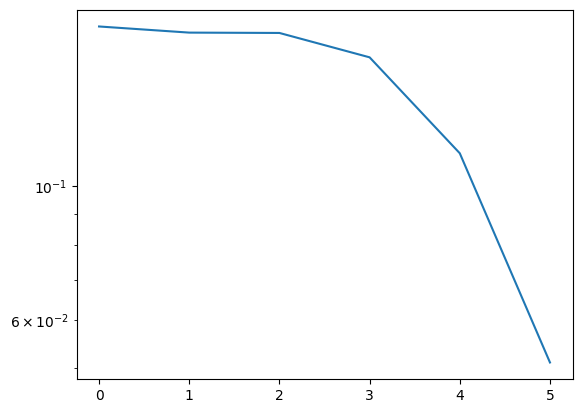

In [20]:
from optimize_sparse import optimize

Vlist, f_iter, err_iter = optimize(L, hamil, t, Vlist_start, perms_extended, perms_reduced=perms_ext_reduced, 
                                   control_layers=control_layers, rS=5, niter=5)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [8]:
with h5py.File(f"./tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_U_1hloc.hdf5", "w") as f:
    f.create_dataset("Vlist", data=Vlist)
    f.create_dataset("f_iter", data=f_iter)
    f.create_dataset("err_iter", data=err_iter)
    f.attrs["L"] = L
    f.attrs["t"] = float(t)